情感分析完成，开始绘图和导出表格。


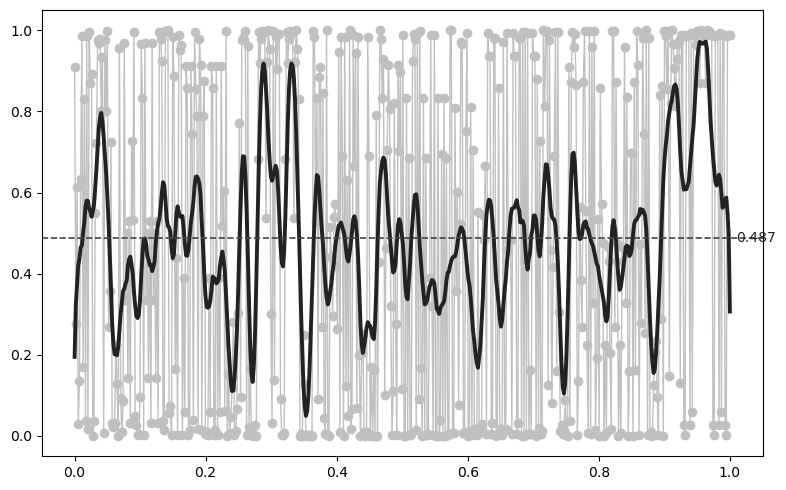

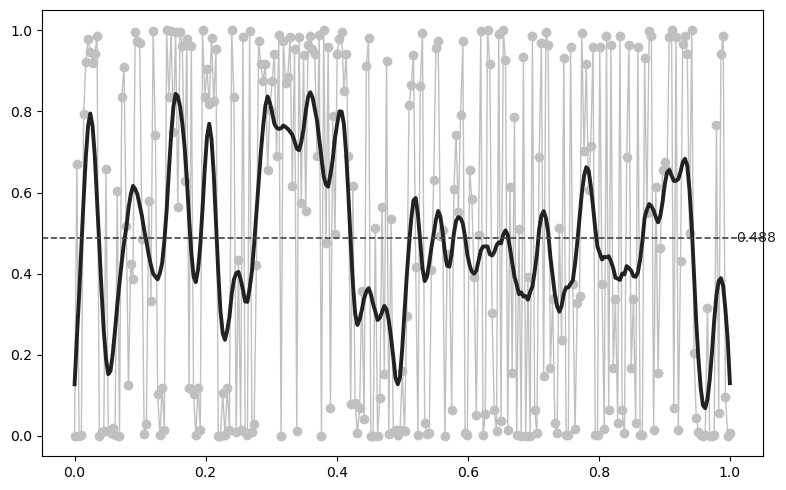

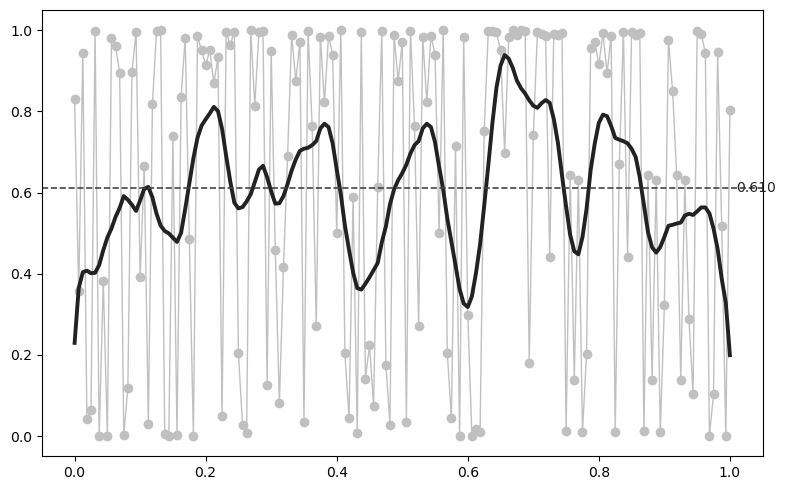

图像与表格均已生成完毕。


In [6]:
import requests
import json
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ------------------- 百度大模型 API 配置 -------------------
API_KEY = "49cIGP3KrzlR1a1yFTFVxjvA"
SECRET_KEY = "0o1yOYOTRfOOnnh1dP0RyUzgfJq2Zp25"

def get_access_token():
    url = "https://aip.baidubce.com/oauth/2.0/token"
    params = {
        "grant_type": "client_credentials",
        "client_id": API_KEY,
        "client_secret": SECRET_KEY
    }
    return requests.post(url, params=params).json().get("access_token")

def sentiment(text, token):
    url = f"https://aip.baidubce.com/rpc/2.0/nlp/v1/sentiment_classify?charset=UTF-8&access_token={token}"
    payload = json.dumps({"text": text}, ensure_ascii=False)
    headers = {"Content-Type": "application/json", "Accept": "application/json"}
    res = requests.post(url, headers=headers, data=payload.encode("utf-8"))
    try:
        return res.json()["items"][0]
    except:
        return None

# ------------------- 角色名称（同义名） -------------------
roles = {
    "于连": ["于连"],
    "德瑞纳夫人": ["德瑞纳夫人", "瑞那夫人"],
    "玛蒂尔德": ["玛蒂尔德", "玛娣儿特"]
}

# ------------------- 提取台词 -------------------
role_lines = {r: [] for r in roles.keys()}

with open("歌剧剧本.txt", "r", encoding="utf-8") as f:
    lines = [l.strip() for l in f.readlines()]

current_speaker = None
for idx, line in enumerate(lines):
    if not line:
        continue
    found_speaker = None
    for role, alias_list in roles.items():
        for alias in alias_list:
            if line.startswith(alias):
                found_speaker = role
                break
        if found_speaker:
            break
    if found_speaker:
        current_speaker = found_speaker
        content = line.split("：", 1)[-1].strip()
        if content:
            role_lines[current_speaker].append(content)
        continue
    if current_speaker:
        role_lines[current_speaker].append(line)

# ------------------- 调用 API 获取情感分数 -------------------
token = get_access_token()
role_scores = {r: [] for r in roles.keys()}

for role, texts in role_lines.items():
    for t in texts:
        time.sleep(0.6)  # QPS 控制
        ana = sentiment(t, token)
        if not ana:
            continue
        role_scores[role].append(ana["positive_prob"])


rows = []
for role, scores in role_scores.items():
    lines = role_lines[role]
    for text, score in zip(lines, scores):
        rows.append([role, text, score])

df = pd.DataFrame(rows, columns=["角色", "台词", "情感分数"])
df.to_csv("情感台词表.csv", index=False, encoding="utf-8-sig")

print("生成完毕。")


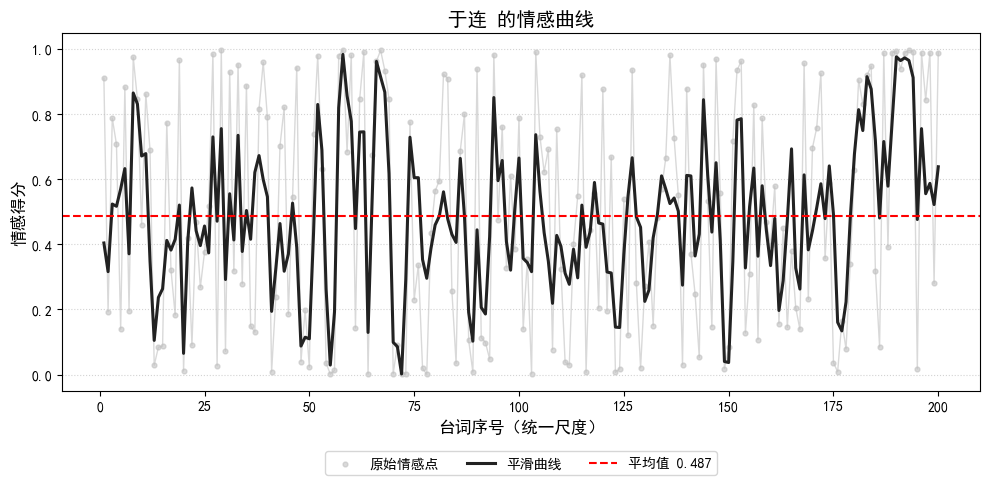

角色 于连 台词总数：542，平均情感值：0.487


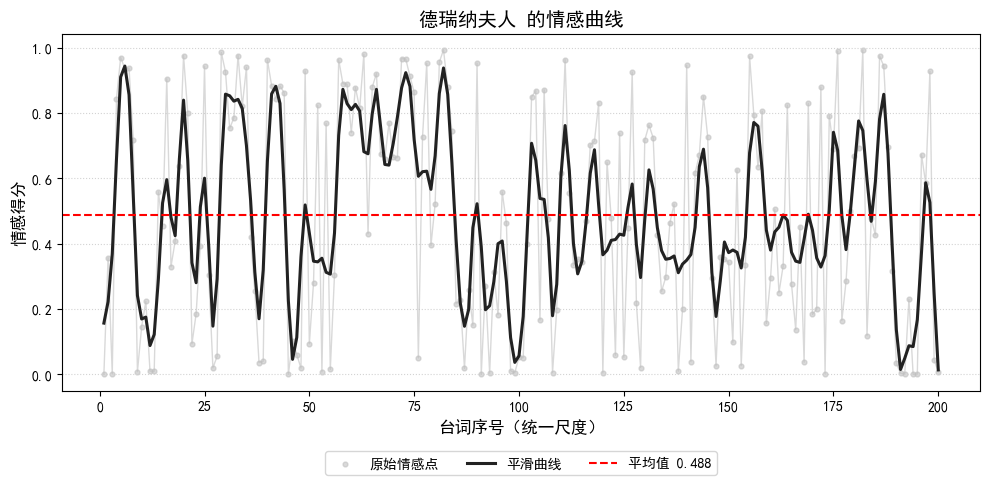

角色 德瑞纳夫人 台词总数：293，平均情感值：0.488


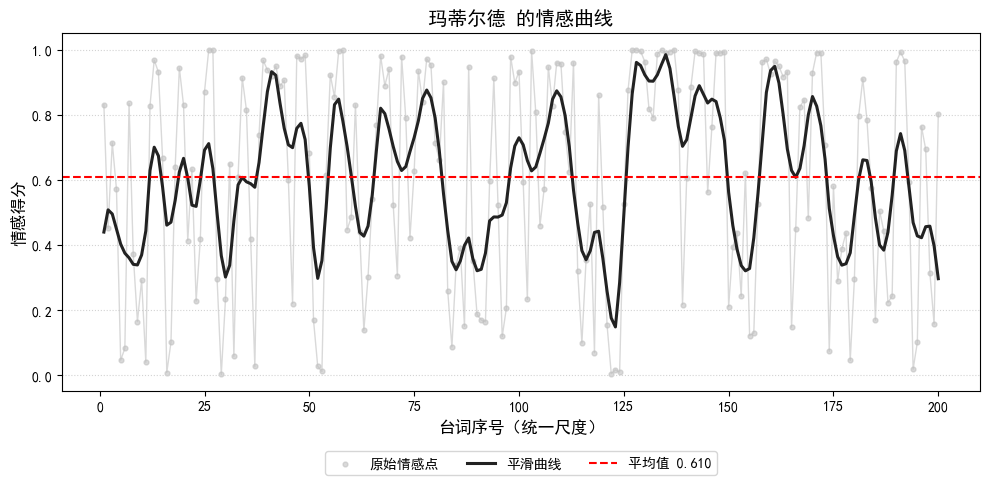

角色 玛蒂尔德 台词总数：161，平均情感值：0.610
所有角色情感曲线已在控制台显示完毕。


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# --------------------------
# 中文显示设置（防止中文乱码）
# --------------------------
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

# --------------------------
# 1. 读取情感台词表
# --------------------------
df = pd.read_csv("情感台词表.csv", encoding="utf-8-sig")

# --------------------------
# 2. 平滑函数（降低平滑强度）
# --------------------------
def super_smooth(values):
    if len(values) < 5:
        return values
    window = 5
    sigma = 1.5
    x = np.arange(window) - window//2
    gauss = np.exp(-0.5 * (x/sigma)**2)
    gauss /= gauss.sum()
    smoothed = np.convolve(values, gauss, mode='same')
    return smoothed

# --------------------------
# 3. 绘图参数
# --------------------------
UNIFIED_LEN = 200
roles = df["角色"].unique()

# --------------------------
# 4. 绘制每个角色情感曲线
# --------------------------
for role in roles:
    subdf = df[df["角色"] == role]
    scores = subdf["情感分数"].tolist()
    N = len(scores)
    if N == 0:
        continue

    # 原始横坐标（统一到 UNIFIED_LEN）
    x_new = np.linspace(1, UNIFIED_LEN, UNIFIED_LEN)

    # 插值原始点到统一长度
    raw_interp = np.interp(x_new, np.linspace(1, UNIFIED_LEN, N), scores)

    # 平滑处理并插值到统一长度
    smooth_scores_val = super_smooth(scores)
    smooth_interp = np.interp(x_new, np.linspace(1, UNIFIED_LEN, N), smooth_scores_val)

    avg = np.mean(scores)

    # ---------- 绘图 ----------
    plt.figure(figsize=(10, 5))

    # 原始情感点（浅灰）
    plt.scatter(
        x_new,
        raw_interp,
        color="#c0c0c0",
        s=12,
        alpha=0.6,
        label="原始情感点"
    )

    # 原始点折线连接（浅灰）
    plt.plot(
        x_new,
        raw_interp,
        color="#c0c0c0",
        linewidth=1.0,
        alpha=0.6
    )

    # 平滑曲线（黑色）
    plt.plot(
        x_new,
        smooth_interp,
        color="#222222",
        linewidth=2.2,
        label="平滑曲线"
    )

    # 平均线（红色）
    plt.axhline(
        avg,
        color="red",
        linestyle="--",
        linewidth=1.5,
        label=f"平均值 {avg:.3f}"
    )

    # 标签与标题
    plt.xlabel("台词序号（统一尺度）", fontsize=12)
    plt.ylabel("情感得分", fontsize=12)
    plt.title(f"{role} 的情感曲线", fontsize=14)

    # 网格
    plt.grid(axis="y", linestyle=":", color="lightgray")

    # 图例显示在图下方
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt.tight_layout()
    plt.show()

    print(f"角色 {role} 台词总数：{N}，平均情感值：{avg:.3f}")

print("所有角色情感曲线已在控制台显示完毕。")
